In [1]:
import os
import sys
import pandas as pd
import numpy as np
root_path = os.path.abspath("..")  
if root_path not in sys.path:
    sys.path.insert(0, root_path)
os.chdir("..")
from IPython.display import display, Markdown

In [2]:
# %pip install itables
from itables import init_notebook_mode
import itables.options as opt

# Ativa o modo interativo
init_notebook_mode(all_interactive=True)
opt.buttons = [
    "copy",
    {
        "extend": "csvHtml5",
        "text": "CSV",          
        "fieldBoundary": "",     
        "extension": ".csv"      
    },
    "excel",
    "pdf"
]
opt.classes = ["display", "nowrap"]
opt.scrollY = "400px"       
opt.scrollCollapse = True   
opt.scrollX = True         
opt.paging = False          

In [3]:
from data.loader import load_complete_dataset, analyze_dataset_quality, load_individual
from data.preprocessing import add_module_columns
dataset = load_complete_dataset()
add_module_columns(dataset)


Loading ITables v2.6.1 from the init_notebook_mode cell... (need help?)


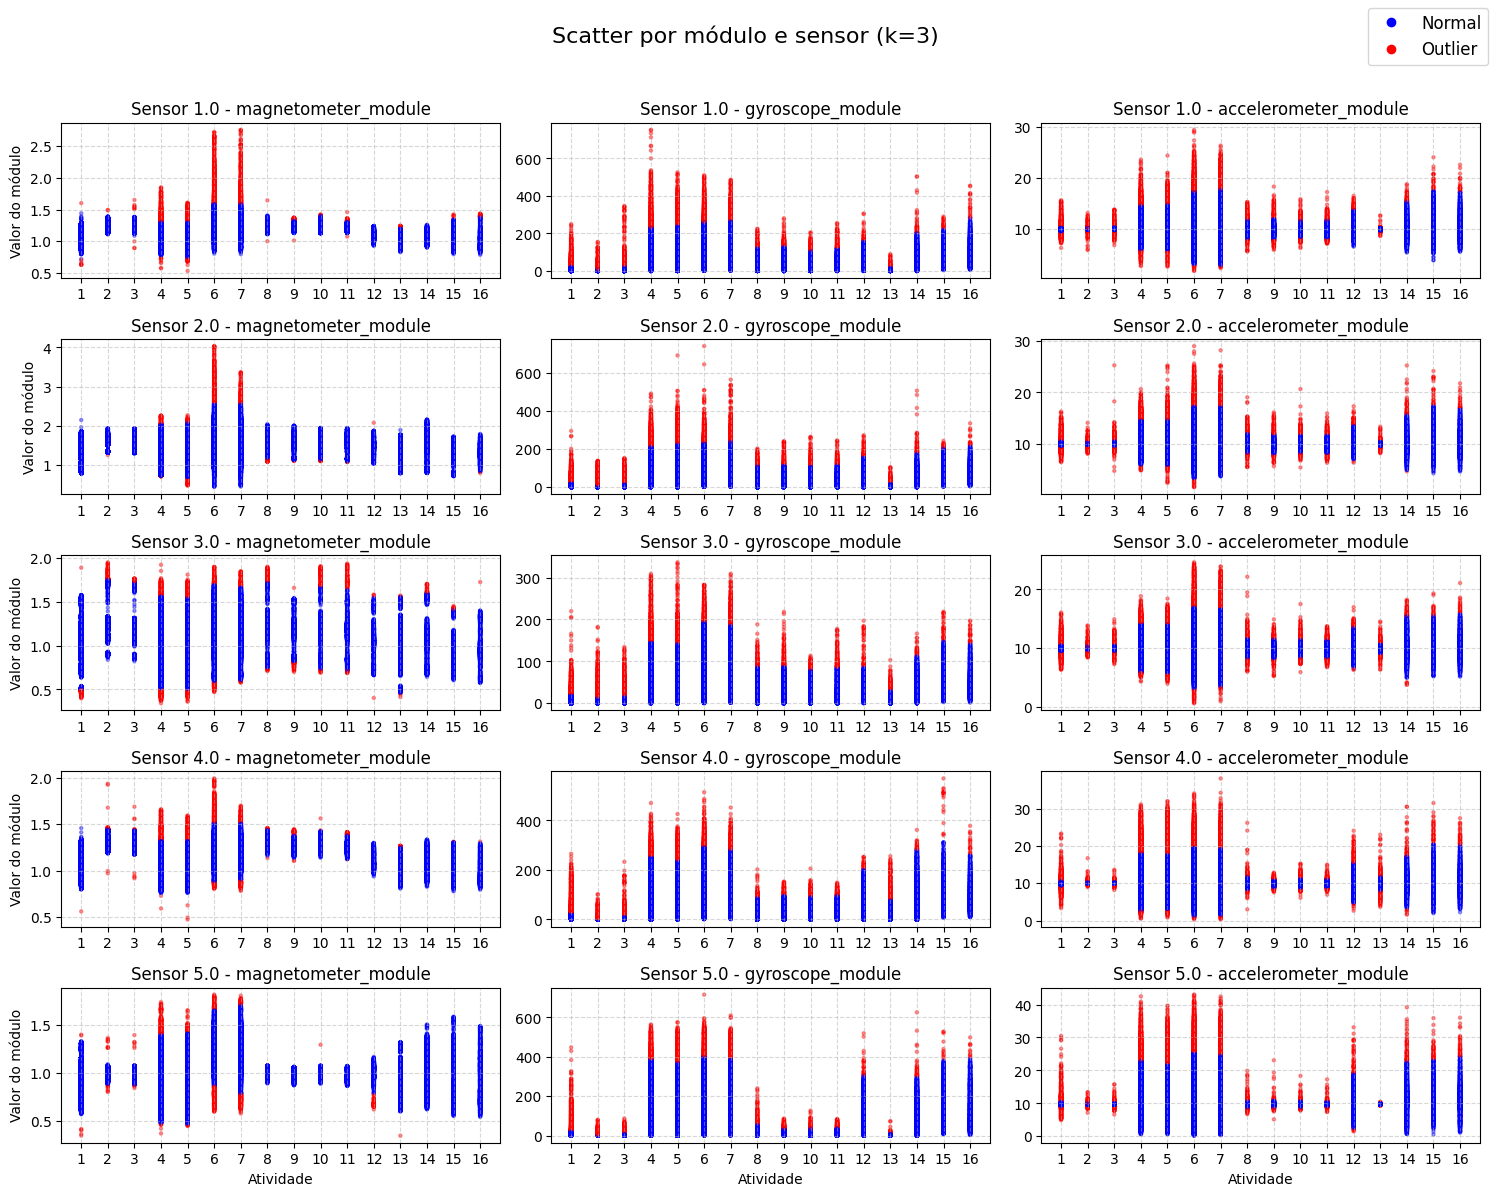

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.lines import Line2D

ks = [3, 3.5, 4]
modules = [
    "magnetometer_module",
    "gyroscope_module",
    "accelerometer_module"
]
os.makedirs("plots_by_sensor", exist_ok=True)
sensors_to_plot = sorted(dataset["device_id"].unique())

# xticks comuns para todos os subplots
all_activities = sorted(dataset["actitivy_label"].unique())

for k in ks:
    fig, axes = plt.subplots(
        len(sensors_to_plot), len(modules), figsize=(15, 12), sharex=False, sharey=False)
    fig.suptitle(f"Scatter por módulo e sensor (k={k})", fontsize=16)

    for i, sensor_id in enumerate(sensors_to_plot):
        sensor_data = dataset[dataset["device_id"] == sensor_id]

        for j, module in enumerate(modules):
            ax = axes[i, j] if len(sensors_to_plot) > 1 else axes[j]

            # calcular outliers por grupo (atividade)
            mean_per_group = sensor_data.groupby("actitivy_label")[module].transform("mean")
            std_per_group = sensor_data.groupby("actitivy_label")[module].transform("std")
            z_scores = (sensor_data[module] - mean_per_group) / std_per_group
            colors = np.where(np.abs(z_scores) > k, "red", "blue")

            X = sensor_data["actitivy_label"].values
            Y = sensor_data[module].values

            ax.scatter(X, Y, s=5, alpha=0.4, c=colors)
            ax.set_title(f"Sensor {sensor_id} - {module}")
            if i == len(sensors_to_plot)-1:
                ax.set_xlabel("Atividade")
            if j == 0:
                ax.set_ylabel("Valor do módulo")    
            ax.grid(True, linestyle='--', alpha=0.5)

            # configurar xticks como inteiros
            ax.set_xticks(all_activities)
            ax.set_xticklabels([int(a) for a in all_activities])

    # legenda global de cores
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='blue', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Outlier', markerfacecolor='red', markersize=8)
    ]
    fig.legend(handles=legend_elements, loc='upper right', fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f"plots_subplots_k{k}.png", dpi=300, bbox_inches='tight')
    plt.show()